In [1]:
!pip install --quiet rasterio

import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import torch.nn as nn
import os
import sys
import importlib.util
import matplotlib.patches as mpatches

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.8 MB/s eta 0:00:00:00:0100:01


In [2]:
# Correct path to your model files
MODEL_DIR = "/kaggle/input/prithivi/pytorch/default/1"
BIG_IMG_PATH = "/kaggle/input/berlin1/Berlin_S2SR_B1_B2_B3_B8_B11_B12.tif"

# Import prithvi_mae.py using the absolute direct path
import sys, importlib.util, os
spec = importlib.util.spec_from_file_location(
    "prithvi_mae", os.path.join(MODEL_DIR, "prithvi_mae.py")
)
prithvi_mae = importlib.util.module_from_spec(spec)
sys.modules["prithvi_mae"] = prithvi_mae
spec.loader.exec_module(prithvi_mae)

# Load config.json
import json
with open(os.path.join(MODEL_DIR, "config.json")) as f:
    config = json.load(f)

print("Config loaded.")

Config loaded.


In [3]:
label2id = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4,
            'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

In [4]:
import torch.nn as nn
import torch

# --- Define Classifier as in train ---
class PrithviEuroSATClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes):
        super().__init__()
        self.encoder = pretrained_mae.encoder
        self.norm = pretrained_mae.encoder.norm  # not always used, but included for completeness
        self.cls_head = nn.Linear(self.encoder.embed_dim, num_classes)
    def forward(self, x):
        if len(x.shape) == 4:
            x = x.unsqueeze(2)
        features = self.encoder(x)[0]   # [B, num_tokens+1, embed_dim]
        cls_tok = features[:, 0]
        logits = self.cls_head(cls_tok)
        return logits

# --- Instantiate model ---
NUM_CLASSES = len(label2id)   # Make sure label2id dict is defined as before
pretrained_mae = prithvi_mae.PrithviMAE(**config['pretrained_cfg'])
model = PrithviEuroSATClassifier(pretrained_mae, NUM_CLASSES)

# --- Load finetuned weights only! ---
ckpt = torch.load(os.path.join(MODEL_DIR, "best_prithvi_eurosat.pt"), map_location="cpu")
model.load_state_dict(ckpt)
model = model.eval()
if torch.cuda.is_available():
    model = model.cuda()
print("Full classifier ready!")

Full classifier ready!


In [8]:
import numpy as np
import torch

# Make sure to use the correct band indices based on how your TIFF is written.
# For EuroSAT, these are the default: [1,2,3,8,10,11] (Blue,Green,Red,NIR,SWIR1,SWIR2), 1-based index for rasterio
BAND_INDICES =  [1, 2, 3, 4, 5, 6]    # For your 6-band GEE export

# If you normalized with a particular mean/std during training, apply here.
TRAIN_MEANS = np.array([1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0]).reshape(-1,1,1)
TRAIN_STDS  = np.array([2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0]).reshape(-1,1,1)

def read_patch(src, x, y, patch_size):
    arr = src.read(BAND_INDICES, window=rasterio.windows.Window(x, y, patch_size, patch_size), boundless=True, fill_value=0)
    arr = arr.astype(np.float32)  # <--- here, should be float32
    arr = (arr - TRAIN_MEANS) / TRAIN_STDS
    return arr

def infer_patch(model, patch_tensor):
    # Ensure patch_tensor is float32
    patch_tensor = patch_tensor.astype(np.float32)
    with torch.no_grad():
        patch_tensor = torch.from_numpy(patch_tensor).unsqueeze(0)  # [1, 6, H, W]
        patch_tensor = patch_tensor.float()
        if torch.cuda.is_available():
            patch_tensor = patch_tensor.cuda()
        logits = model(patch_tensor)
        pred = logits.argmax(dim=1).item()
    return pred

In [9]:
import types

def patched_forward(self, x, temporal_coords=None, location_coords=None, mask_ratio=0.75):
    # Patch for device consistency (pos_embed to x.device)
    if len(x.shape) == 4 and self.patch_embed.input_size[0] == 1:
        x = x.unsqueeze(2)
    sample_shape = x.shape[-3:]
    x = self.patch_embed(x)
    pos_embed = self.interpolate_pos_encoding(sample_shape)
    pos_embed = pos_embed.to(x.device)         # Ensure on the same device!
    x = x + pos_embed[:, 1:, :]
    if self.temporal_encoding and temporal_coords is not None:
        num_tokens_per_frame = x.shape[1] // self.num_frames
        temporal_encoding = self.temporal_embed_enc(temporal_coords, num_tokens_per_frame)
        x = x + temporal_encoding
    if self.location_encoding and location_coords is not None:
        location_encoding = self.location_embed_enc(location_coords)
        x = x + location_encoding
    x, mask, ids_restore = self.random_masking(x, mask_ratio)
    cls_token = self.cls_token + pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    for block in self.blocks:
        x = block(x)
    x = self.norm(x)
    return x, mask, ids_restore

# Patch model encoder's forward
model.encoder.forward = types.MethodType(patched_forward, model.encoder)

In [10]:
import numpy as np
import rasterio
from tqdm.notebook import tqdm
import torch

PATCH_SIZE = 64
STRIDE = 64  # NO overlap
BATCH_SIZE = 1024  # Set as high as your GPU can handle

with rasterio.open(BIG_IMG_PATH) as src:
    width, height = src.width, src.height
    print(f"Input image shape: H={height}, W={width}")

    pred_map = np.full((height, width), fill_value=-1, dtype=np.int16)
    steps_y = list(range(0, height, STRIDE))
    steps_x = list(range(0, width, STRIDE))
    total_patches = len(steps_y) * len(steps_x)

    xy_locations = [(x, y) for y in steps_y for x in steps_x]

    batch_patches = []
    batch_coords = []

    for idx in tqdm(range(len(xy_locations)), total=total_patches, desc="Classifying patches (batched)"):
        x, y = xy_locations[idx]
        patch = read_patch(src, x, y, PATCH_SIZE)
        batch_patches.append(patch)
        batch_coords.append((x, y))

        if len(batch_patches) == BATCH_SIZE or idx == total_patches - 1:
            batch_np = np.stack(batch_patches).astype(np.float32)
            batch_tensor = torch.from_numpy(batch_np)
            if torch.cuda.is_available():
                batch_tensor = batch_tensor.cuda()
            with torch.no_grad():
                logits = model(batch_tensor)
                batch_preds = logits.argmax(dim=1).cpu().numpy()
            for pred, (bx, by) in zip(batch_preds, batch_coords):
                pred_map[by:by+PATCH_SIZE, bx:bx+PATCH_SIZE] = pred
            batch_patches.clear()
            batch_coords.clear()

print("Inference complete! Unique classes predicted:", np.unique(pred_map))

Input image shape: H=3760, W=7489


Classifying patches (batched):   0%|          | 0/6962 [00:00<?, ?it/s]

Inference complete! Unique classes predicted: [0 1 2 3 4 5 8 9]


In [12]:
import rasterio
import numpy as np

with rasterio.open(BIG_IMG_PATH) as src:
    img = src.read([1, 2, 3, 4, 5, 6])
    # Find 'real data' pixels: any pixel with all bands zero is outside the AOI
    # Better: use a threshold (GeoTIFF may have zeros/low everywhere outside AOI)
    mask = np.max(img, axis=0) > 10  # 10 is a safe low threshold

# Use this mask to mask your pred_map
masked_pred_map = np.where(mask, pred_map, -1)

/tmp/ipykernel_36/1941515752.py:8: RuntimeWarning: invalid value encountered in greater
  mask = np.max(img, axis=0) > 10  # 10 is a safe low threshold


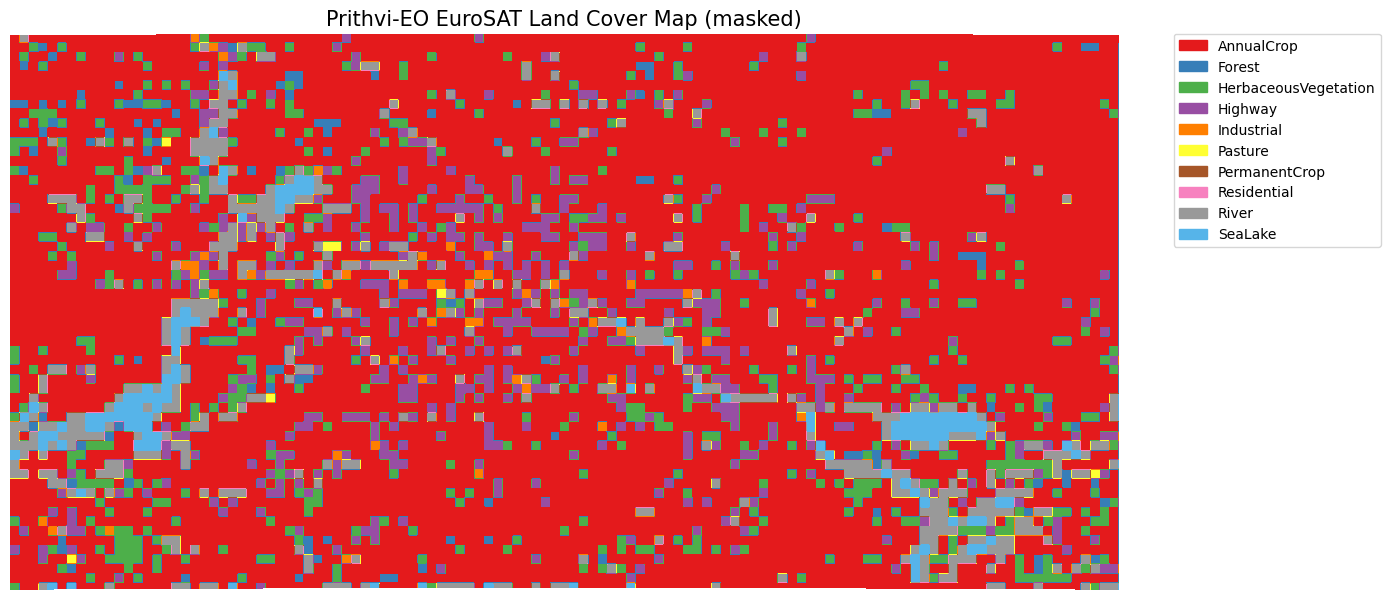

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

class_names = [k for k, v in sorted(label2id.items(), key=lambda x: x[1])]

# Very clear, color-different palette (ColorBrewer Set1)
cmap = mcolors.ListedColormap([
    "#e41a1c",  # red - AnnualCrop
    "#377eb8",  # blue - Forest
    "#4daf4a",  # green - HerbaceousVegetation
    "#984ea3",  # purple - Highway
    "#ff7f00",  # orange - Industrial
    "#ffff33",  # yellow - Pasture
    "#a65628",  # brown - PermanentCrop
    "#f781bf",  # pink - Residential
    "#999999",  # gray - River
    "#56B4E9",  # cyan - SeaLake
])

# Masked array for transparent background
masked_array = np.ma.masked_equal(masked_pred_map, -1)

plt.figure(figsize=(14, 10))
im = plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=9)
handles = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axis('off')
plt.title("Prithvi-EO EuroSAT Land Cover Map (masked)", fontsize=15)
plt.tight_layout()
plt.show()

,class,pixels,fraction
0,AnnualCrop,20592185,0.732348
3,Highway,2198129,0.078175
6,River,2073413,0.073740
2,HerbaceousVegetation,2036224,0.072417
7,SeaLake,509652,0.018125
1,Forest,479232,0.017044
4,Industrial,200512,0.007131
5,Pasture,28672,0.001020


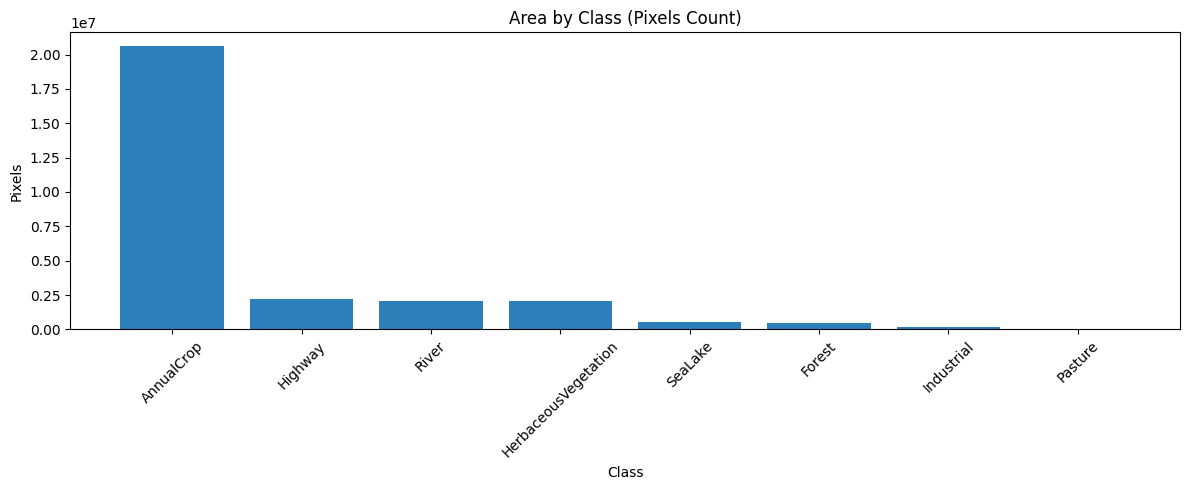

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute stats ONLY for the AOI
unique, counts = np.unique(masked_pred_map[masked_pred_map >= 0], return_counts=True)
areas = {class_names[int(idx)]: int(cnt) for idx, cnt in zip(unique, counts)}

import pandas as pd
area_df = pd.DataFrame({"class": list(areas.keys()), "pixels": list(areas.values())})
area_df['fraction'] = area_df['pixels'] / mask.sum()  # Use only AOI pixel count
area_df = area_df.sort_values("pixels", ascending=False)
display(area_df)


plt.figure(figsize=(12, 5))
plt.bar(area_df['class'], area_df['pixels'], color="#2c7fb8")
plt.title("Area by Class (Pixels Count)")
plt.ylabel("Pixels")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
import rasterio

with rasterio.open(BIG_IMG_PATH) as src:
    profile = src.profile
profile.update(dtype=rasterio.int16, count=1)

with rasterio.open("classified_map.tif", "w", **profile) as dst:
    dst.write(pred_map.astype(rasterio.int16), 1)
print("GeoTIFF saved as classified_map.tif")

GeoTIFF saved as classified_map.tif


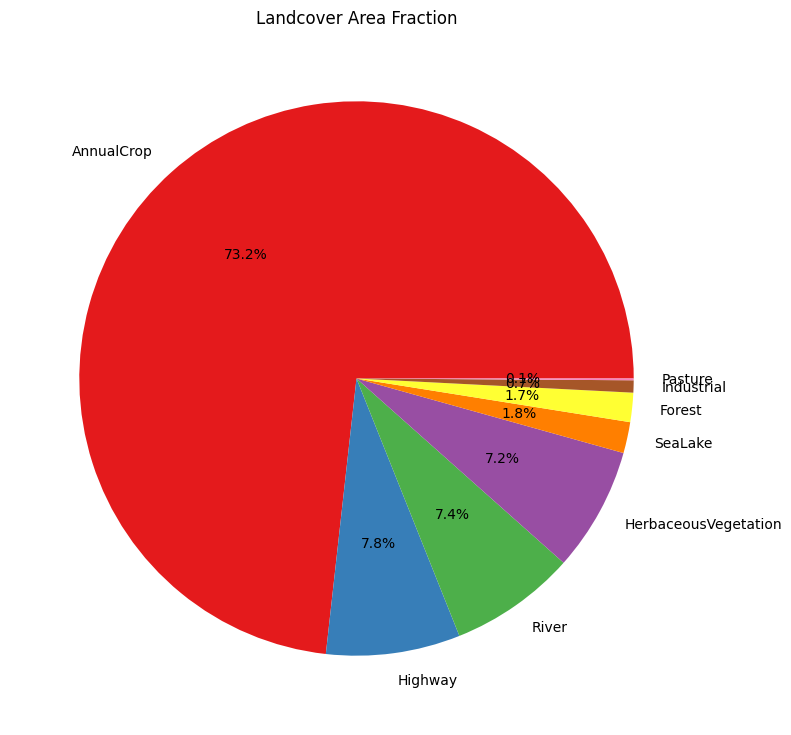

In [17]:
area_df = area_df.sort_values("pixels", ascending=False)
plt.figure(figsize=(9, 9))
plt.pie(area_df["pixels"], labels=area_df["class"], autopct='%1.1f%%', colors=cmap.colors)
plt.title("Landcover Area Fraction")
plt.show()